In [7]:
# python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import astropy as ap
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import pandas as pd
import math
import statistics

# lenstronomy imports
from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit

In [36]:
# define some useful functions

def get_data(filename, coadd_id):  
    """Input filename and coadd_id returns fwhm of g,r,i bands and image data"""
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data) # get dataframe data
    image = hdu_list['IMAGE'].data # get image data
    hdu_list.close() # close
    
    return data, image

def plot_image(image_array):
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin = 'lower')    
    plt.show()
    plt.close()

def approx_theta_E(center_x, center_y, x_images, y_images): 
    d=[]
    for i in range(0, len(x_images)):
        x=float(x_images[i])
        y=float(y_images[i])

        x=center_x-x
        y=center_y-y
        dist=math.sqrt(x**2+y**2)
        d.append(dist)

    theta_E = statistics.mean(d)

    print(f"'theta_E': {round(theta_E,2)}")
    return theta_E

In [37]:
# set filename
filepath = '/Users/gilliancartwright/Desktop/summerproject/' # my personal file path
filename = filepath + 'Quasars.fits'

# show data table for reference
hdu_list = fits.open(filename)
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
#print(data.columns) # view all column names
data.head(10)


,NAME,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,...,IMAFLAGS_ISO_I,IMAFLAGS_ISO_Z,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z
0,DESJ0112-1650,1146879846,DES0112-1707,1098276694,68642293,0.291241,18.141220,-16.840985,3.932359,3.878177,...,0,0,1.058140,0.920101,0.841518,0.787317,414.192993,1118.079956,3729.070068,7356.490234
1,DESJ0501-4118,1532350418,DES0503-4123,2241453493,140090843,0.101100,75.441381,-41.300335,3.099320,3.545753,...,0,0,1.081290,1.027810,0.867825,0.901882,320.069000,927.046997,2752.050049,4901.779785
2,DESJ0245-0556,1330959670,DES0245-0541,2413991670,150874479,0.111465,41.356534,-5.950162,3.055968,2.874859,...,0,0,1.116340,0.952896,0.927758,0.921189,411.776001,1180.140015,2899.929932,8013.839844
3,DESJ0150-4041,1212441684,DES0151-4040,2310061785,144378861,0.221885,27.736982,-40.695591,3.898210,4.267331,...,0,0,1.040950,0.979799,0.924899,0.888690,375.178009,995.431030,3212.100098,8518.379883
4,DESJ2349-4518,1025921566,DES2350-4457,3041123543,190070221,0.578291,357.492430,-45.314703,3.090863,2.935678,...,0,0,1.194170,1.016470,0.880288,0.853919,350.524994,1179.099976,3281.679932,7779.839844
5,DESJ0053-2012,1112574265,DES0054-1958,1097005026,68562814,0.281026,13.435369,-20.209280,3.177962,3.091353,...,0,0,0.961043,0.893971,0.906943,0.818007,425.548004,1079.760010,3087.939941,7383.299805
6,DESJ0600-4649,1596823754,DES0600-4706,2592244634,162015289,0.687135,90.124273,-46.816784,3.107268,2.793631,...,0,0,1.116370,0.948714,0.867564,0.842476,376.791992,988.254028,3297.439941,6159.589844
7,DESJ0246-1845,1331771342,DES0246-1832,2388525430,149282839,1.822159,41.551028,-18.751365,3.343046,2.975646,...,0,0,1.195220,1.014710,0.921888,0.813008,425.429993,1041.430054,2953.820068,8456.799805
8,DESJ0340-2545,1406996169,DES0340-2541,2367950868,147996929,0.101100,55.035151,-25.760991,3.711554,3.677533,...,0,0,1.176360,0.950206,0.893435,0.949142,361.473999,1013.770020,3099.550049,8957.809570
9,DESJ0407-1931,1456100148,DES0406-1915,2371528735,148220545,0.237287,61.974158,-19.522548,4.376297,4.108721,...,0,0,1.126060,0.980889,0.916621,0.850487,384.920013,1001.849976,3119.899902,6937.060059


Column names and meanings: 
* HPIX_16384: Healpix index for NSIDE = 16384 in NEST schema for the object
* HPIX_4096: Healpix index for NSIDE = 4096 in NEST schema for the object
* DNF_ZMEAN_SOF: DNF photo-z Mean statistic (obtained from fitted hyperplane) using corrected SOF fluxes
* FLUX_RADIUS_(GRIZ): Radius of the circle centered around the barycenter of the object containing half of the flux of the object
* KRON_RADIUS: DET image A luminosity weighted radius, encompassing approximately >~90% of the total flux
* GAP_FLUX_G: Gaussian Aperture fluxes with FWHM=4''
* MOF_BDF_FLUX_G: MOF CM FLUX MAG=30-2.5*log10(FLUX)
* MOF_PSF_FLUX_G: MOF PSF flux MAG=30-2.5*log10(FLUX)
* SOF_BDF_FLUX_G: SOF CM FLUX MAG=30-2.5*log10(FLUX)
* SOF PSF flux MAG=30-2.5*log10(FLUX)
* MAG_AUTO_G: ???
* MAG_APER_4_G: Magnitude measured in a circular aperture of 2 arcsecs
* MAG_APER_8_G: Magnitude measured in a circular aperture of 6 arcsecs
* SOF_BDF_G_1, SOF_BDF_G_2: SOF based shape component 1 (reduced version of e1, e2)
* IMAFLAGS_ISO_(GRIZ): IMAGE FLAG bitS set within the ISOphotoal radius for the object. 0: ok 1: Indicates an area in the coadd with missing data or a very bright star
* SKYBRITE_WMEAN_(GRIZ): ???

In [10]:
# Data Specifics for DES camera
background_rms = 7.  # background noise per pixel 
exp_time = 90.  # exposure time 
numPix = 46  # cutout pixel size per axis
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'

In [38]:
### MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_lens_light_initial, #kwargs_source_initial
          x_images, y_images, image_amps_g, image_amps_r,image_amps_i, mask_list):
    """ 
    INPUT: coadd_id of image, initial lens model and light parameters, 
    list of x coords and y coords of images, 
    lists of image amplitudes for g,r,i bands,
    OPTIONAL: mask list
    
    OUTPUT: RGB image, observed image, reconstructed image, residuals plot, 
    and results of PSO and MCMC fitting
    
    """
    ## Image data
    data, image = get_data(filename, coadd_id)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row,0,:,:]
    r = image[row,1,:,:]
    i = image[row,2,:,:]
    
    fwhm_g = data.iloc[row,27]
    fwhm_r = data.iloc[row,28]
    fwhm_i = data.iloc[row,29] 
    
    # set models to use
    lens_model_list = ['SIE'] # not using SHEAR because it is too degenerate with model
    #source_model_list = ['SERSIC_ELLIPSE'] 
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
    
    # generate image data for each band
    kwargs_data_g = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  # translate between pixels and RA, DEC
               'image_data': g, # 2d data vector of band image
                    }  
    
    kwargs_data_r = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': r,
                    }  
    
    kwargs_data_i = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord, 
               'image_data': i,
                    } 
    
    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': deltaPix, 'truncation': 3}
     
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}    
    
    # Option to add mask(s)
    # Masks must be added to mask_list in the form:
    # mask_list = [{'mask_center_x': _, 'mask_center_y': _, 'mask_radius': _}, ...]
    if mask_list:
        # get 2d grid for ra and dec
        ra_grid_2d, dec_grid_2d = util.array2image(ra_grid), util.array2image(dec_grid)
        
        def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,
               'image_data': masked_image}  
            
            return kwargs_data, masked_image
        
        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_center_x'), 
                                               center_y=mask.get('mask_center_y'), 
                                               r=mask.get('mask_radius'), 
                                               x_grid=ra_grid_2d, y_grid=dec_grid_2d)
            # call function to add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i)
            
        # plots each band with mask(s) for reference 
        fig, ax = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)
        ax[0].imshow(g, origin='lower', cmap='gray', alpha=0.5)
        ax[1].imshow(r, origin='lower', cmap='gray', alpha=0.5)
        ax[2].imshow(i, origin='lower', cmap='gray', alpha=0.5)
        ax[0].text(0,numPix-5, 'G-Band', color="w", backgroundcolor='k', fontsize = 14)
        ax[1].text(0,numPix-5, 'R-Band', color="w", backgroundcolor='k', fontsize = 14)
        ax[2].text(0,numPix-5, 'I-Band', color="w", backgroundcolor='k', fontsize = 14) 
        plt.show()
        plt.close()
        
    elif mask_list == None:
        pass
    else:
        print('Please add mask or set mask_list=None')
    
    ## Settings for model
    # set models: 
    lens_model_list = ['SIE', 
                       #'SHEAR'
                      ] 
    lens_light_model_list = ['SERSIC_ELLIPSE'] # sersic light profile
    point_source_list = ['LENSED_POSITION'] # input for point source is image positions, not source position
    #source_model_list = ['SERSIC'] 
        
    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    #'source_light_model_list': source_model_list, 
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # mag. ratio of point source is not fixed to the one given by lens model 
        
    # tell kwargs_constraints how to solve based on the number of images 
    ps_images = len(x_images) # number of images of the point source
    if ps_images == 4:
        solver_type = 'PROFILE' #'PROFILE_SHEAR'
    elif ps_images == 3 or ps_images == 1:
        solver_type='NONE'
    elif ps_images == 2: 
        solver_type = 'ELLIPSE'
    else:
        print('INVALID NUMBER OF IMAGES FOR SIE MODEL. CHANGE LENS MODEL OR PS_IMAGES')

    kwargs_constraints = { 'num_point_source_list': [ps_images], 
                          #'solver_type': solver_type, 
                         #'joint_source_with_point_source': [[0, 0]] 
                         }

    kwargs_likelihood = {'check_bounds': True, # punishing factor for image positions
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001
                         } # see lenstronomy_extensions notebook: quad modelling for more info on these

    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
    
    # add flux ratios:
    #BREAK
    def get_flux_ratios(image_amps):
        flux_ratios=[]
        for amp in image_amps[1:]:
                flux_ratios.append(amp/image_amps[0])
        kwargs_data_joint.update({'flux_ratios': flux_ratios})
        return kwargs_data_joint
    
    kwargs_data_joint=get_flux_ratios(image_amps_g)
    kwargs_data_joint=get_flux_ratios(image_amps_r)
    kwargs_data_joint=get_flux_ratios(image_amps_i)
    
        
    ## Add parameters to model:    
    # lens
    kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    # lens model
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens.append({'theta_E': 5, 'e1': 0.5, 'e2': 0.5,  'center_x': 2, 'center_y': 2})

    # add shear to lens
    #kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
    #kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    #kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    #kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2}]
    kwargs_upper_lens_light = [{'R_sersic': 7, 'n_sersic': 4., 'e1': 0.5, 'e2': 0.5, 'center_x': 2, 'center_y': 2}]

    # point source image positions (loose constraints on image positions)
    #kwargs_ps_fixed = [{}]
    #kwargs_ps_init = [kwargs_ps_initial]
    #kwargs_ps_sigma = [{'ra_image': [0.02] * ps_images, 'dec_image': [0.02] * ps_images}]
    #kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]
    #kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]
    # point source image positions (tight constraints on image positions)
    kwargs_ps_fixed = [{}]
    kwargs_ps_init = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.2] * ps_images, 'dec_image': [0.2] * ps_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.7 for i in x_images], 'dec_image': [i-0.7 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.7 for i in x_images], 'dec_image': [i+0.7 for i in y_images]}]
    
    # source light
    #kwargs_source_fixed = [{}]
    #kwargs_source_init = [kwargs_source_initial]
    #kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
    #kwargs_lower_source = [{'R_sersic': 0.01, 'n_sersic': .5, 'center_x': -2, 'center_y': -2}]
    #kwargs_upper_source = [{'R_sersic': 7, 'n_sersic': 5.,  'center_x': 2, 'center_y': 2}]
    #source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]


    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params, 
                    #'source_model': source_params 
                    }

    ## Fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 50}],
                           ['MCMC', {'n_burn': 40, 'n_run': 120, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    ## Show results
    # plot observed, reconstructed, and residual plots
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)

    # make RGB image 
    rgb_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    axes[0].imshow(rgb_data, origin = 'lower')
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(0,numPix-5, 'RGB Image', color="w", backgroundcolor='k', fontsize = 14)
    
    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)
        
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    plt.close()
    # print actual results
    print(kwargs_result)
    print(f"Model Results: theta_E ={round(kwargs_result.get('kwargs_lens')[0].get('theta_E'),2)}")


    

'theta_E': 0.43


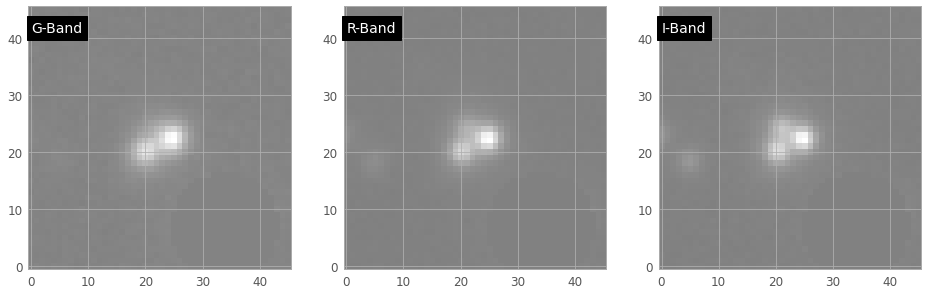

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.8997896266923873 reduced X^2 of best position
-6007.134799601328 logL
6324.0 effective number of data points
[{'theta_E': 0.9038506669535953, 'e1': -0.44299481759713094, 'e2': -0.31730091005639977, 'center_x': -0.673879275917768, 'center_y': 0.19072758816981886}] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.06017175769908, 'n_sersic': 2.639578313302344, 'e1': 0.1503762408524654, 'e2': 0.12404182968483124, 'center_x': -0.468702521283847, 'center_y': 0.4083698630812733}] lens light result
[{'ra_image': array([-0.58777418,  0.48752431]), 'dec_image': array([-0.781907  , -0.05865735]), 'point_amp': array([1., 1.])}] point source result
{} special param result
10.85198712348938 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [02:02<00:00,  1.30it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
123.49615287780762 time taken for MCMC sampling
-1.260914365322271 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.1434316157408843
reduced chi^2 of data  1 =  0.7909729491778724
reduced chi^2 of data  2 =  2.8483385310480567


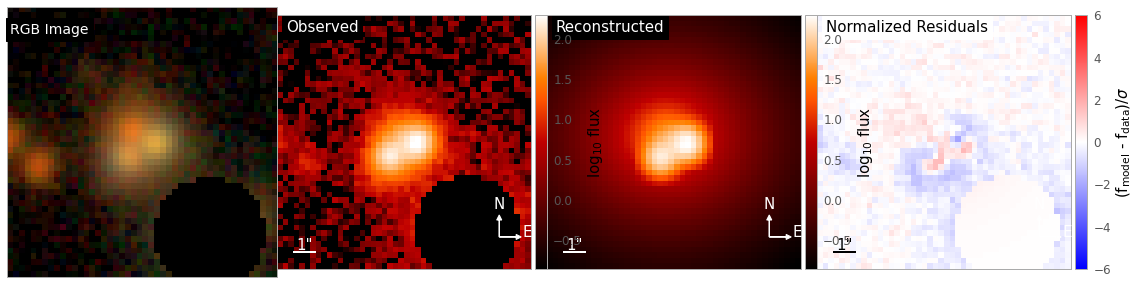

{'kwargs_lens': [{'theta_E': 0.9682032586942567, 'e1': -0.4252217938827833, 'e2': -0.15758899380130212, 'center_x': -0.5602300239175276, 'center_y': 0.3124373560861815}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 395.7859958459648, 'R_sersic': 2.0300127438776805, 'n_sersic': 2.9172560837708024, 'e1': 0.07647653207995443, 'e2': 0.0013395687973455153, 'center_x': -0.35085276089888917, 'center_y': 0.26711628176345475}], 'kwargs_ps': [{'ra_image': array([-0.60812508,  0.6016381 ]), 'dec_image': array([-0.72873518, -0.0764821 ]), 'point_amp': array([5223.13154581, 7519.02845767])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =0.97
Actual: theta_E=0.77 +- 0.01


In [24]:
### coadd_id = 1146879846

### measured values
# lens position
center_x=-0.56
center_y=0.38

# image positions
x_images = [-0.77,0.33]
y_images = [-0.92,-0.16]

# image amps:
image_amps_g = [1162.8, 1912.3]
image_amps_r = [2504.7, 4581.9]
image_amps_i = [3615.4, 6046.7]


### initial guesses for params:
# approximate theta_E
theta_E=approx_theta_E(center_x, center_y, x_images, y_images)

# set kwargs for lens (kwargs for point source found during modeling)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': -0.05, 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 2, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

### run model
model(coadd_id = 1146879846, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': 3.03 , 'mask_center_y': -4.09, 'mask_radius':2.5}]
     )

# we know this from the STRIDES paper where the data is from
print('Actual: theta_E=0.77 +- 0.01')

In [ ]:
# coadd_id = 1532350418
center_x=-0.5
center_y=0.5

x_images = [-0.0,-3.7]
y_images = [-0.3,0.3]

image_amps_g = [16749.4, 20150.3]
image_amps_r = [21291.7, 23922.3]
image_amps_i = [28689, 31787.7]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1532350418, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -3.8 , 'mask_center_y': 3.2, 'mask_radius':1.4}, 
                   'mask_center_x': 3.6 , 'mask_center_y': -4.1, 'mask_radius':1, 
                   'mask_center_x': 0.1 , 'mask_center_y': -4.6, 'mask_radius':1
                 ]
     )

print('Actual theta_E: 1.97 +- 0.03')

'theta_E': 1.5


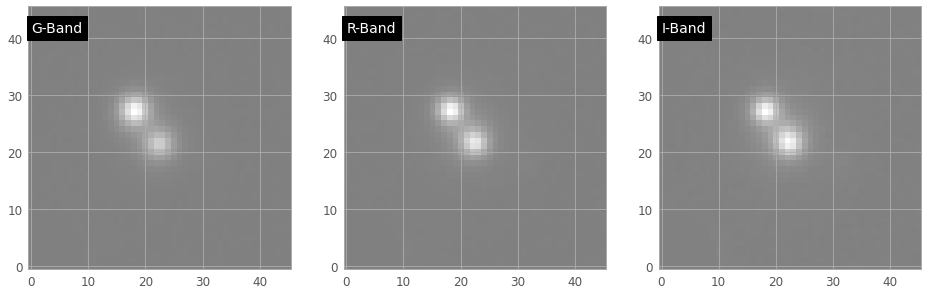

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-2.051021254345462 reduced X^2 of best position
-6485.329206240351 logL
6324.0 effective number of data points
[{'theta_E': 1.472634330748116, 'e1': 0.05051890958826536, 'e2': 0.10387413092891536, 'center_x': 0.04527034704994771, 'center_y': -0.21848348527952774}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.8662732864624024, 'n_sersic': 2.400915586550518, 'e1': -0.08025053363466661, 'e2': -0.16018681931640355, 'center_x': -0.10711275129060122, 'center_y': -0.145613030694102}] lens light result
[{'ra_image': array([-1.18201635,  0.95679101]), 'dec_image': array([ 1.26115488, -0.85626448]), 'point_amp': array([1., 1.])}] point source result
{} special param result
12.296030044555664 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [01:51<00:00,  1.44it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
112.05946612358093 time taken for MCMC sampling
-1.7050194281464066 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.598934750237335
reduced chi^2 of data  1 =  1.728846858009175
reduced chi^2 of data  2 =  1.7872766761927104


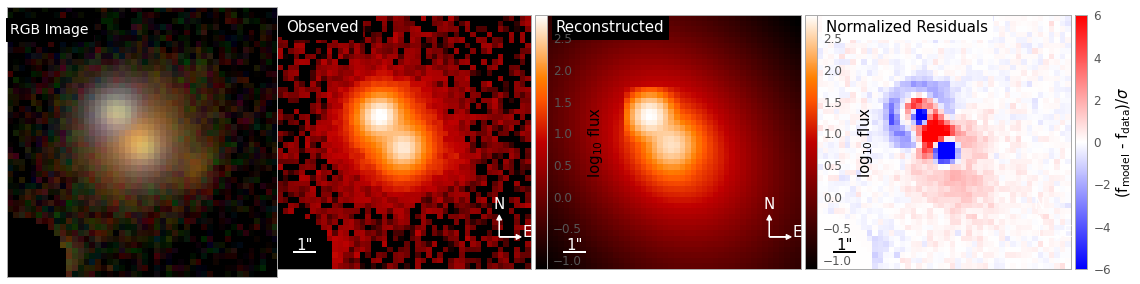

{'kwargs_lens': [{'theta_E': 1.5027983283462265, 'e1': 0.04201148778643529, 'e2': 0.06875987504453872, 'center_x': 0.05772627779008026, 'center_y': -0.256141089551793}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 2495.8349630212206, 'R_sersic': 0.9549112574160019, 'n_sersic': 2.4036240528135115, 'e1': -0.025303579048759083, 'e2': -0.12042865188119317, 'center_x': -0.124010171995697, 'center_y': -0.1413838547616192}], 'kwargs_ps': [{'ra_image': array([-1.13586664,  0.91124617]), 'dec_image': array([ 1.26150393, -1.01428939]), 'point_amp': array([16006.61450129,  -886.35308831])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.5
Actual theta_E: 0.90 +- 0.02


In [26]:
# coadd_id = 1330959670
center_x=-0.18
center_y=-0.08

x_images = [-1.4,0.5]
y_images = [1.3,-0.8]

image_amps_g = [12749.7, 8672.2]
image_amps_r = [15258.5, 14319.3]
image_amps_i = [16652.0, 18111.6]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1330959670, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x':-5.8, 'mask_center_y':-5.8, 'mask_radius':2.5}]
     )

print('Actual theta_E: 0.90 +- 0.02')

'theta_E': 1.34
Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.9061949876903108 reduced X^2 of best position
-2865.3885510767627 logL
6324.0 effective number of data points
[{'theta_E': 1.4812958775469993, 'e1': 0.04221942587743316, 'e2': 0.10036334944896176, 'center_x': -0.22756456500854355, 'center_y': -0.08258360153114973}] lens result
[] source result
[{'amp': 1, 'R_sersic': 3.0905893893034255, 'n_sersic': 3.967142733337922, 'e1': 0.09184837320239841, 'e2': 0.0689198625292295, 'center_x': -0.10852948451207146, 'center_y': 0.0755221533100972}] lens light result
[{'ra_image': array([-2.21230549,  0.64829863]), 'dec_image': array([0.080531  , 0.13807909]), 'point_amp': array([1., 1.])}] point source result
{} special param result
10.35265302658081 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [01:53<00:00,  1.41it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
114.18160390853882 time taken for MCMC sampling
-0.8367065268403664 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.5030502715645574
reduced chi^2 of data  1 =  0.6488072495233885
reduced chi^2 of data  2 =  1.3582620594331531


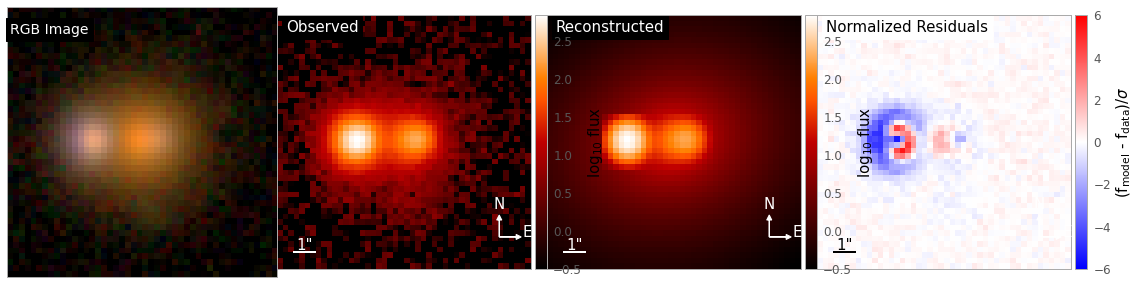

{'kwargs_lens': [{'theta_E': 1.428264524902098, 'e1': 0.011940565673556492, 'e2': 0.1038468215519594, 'center_x': -0.245708032305745, 'center_y': -0.09409320104703175}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 299.529881269519, 'R_sersic': 3.096737644451113, 'n_sersic': 3.8901732261072968, 'e1': 0.10421407591346515, 'e2': 0.05237822072701669, 'center_x': -0.12103758692794979, 'center_y': 0.07809716982832704}], 'kwargs_ps': [{'ra_image': array([-2.20564222,  0.5818751 ]), 'dec_image': array([0.07671215, 0.1155875 ]), 'point_amp': array([19144.43641796,  4337.17662295])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.43
Actual theta_E: 1.44 +- 0.02


In [27]:
# coadd_id = 1212441684
center_x=-0.2
center_y=-0.1

x_images = [-2.4,1.0]
y_images = [0.0,0.0]

image_amps_g = [10400.3, 3178.5]
image_amps_r = [12994.9, 7080.4]
image_amps_i = [18050.0, 11491.3]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 3, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1212441684, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= None)

print('Actual theta_E: 1.44 +- 0.02')

'theta_E': 2.12
Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-30.999403949890368 reduced X^2 of best position
-98020.11528955335 logL
6324.0 effective number of data points
[{'theta_E': 0.8686545061393958, 'e1': -0.48603644605327506, 'e2': -0.4988742651943501, 'center_x': 1.381198901788472, 'center_y': 0.30252622045720534}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9626206847649148, 'n_sersic': 0.7515718885526618, 'e1': 0.37599698715015634, 'e2': 0.18059620592996609, 'center_x': -1.9627354841214293, 'center_y': 0.26247713472297163}] lens light result
[{'ra_image': array([0.39762844, 2.04993315]), 'dec_image': array([-0.27138187,  0.34225529]), 'point_amp': array([1., 1.])}] point source result
{} special param result
6.120794057846069 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [01:42<00:00,  1.56it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
103.39108300209045 time taken for MCMC sampling
-13.625609344163966 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  7.745836947920896
reduced chi^2 of data  1 =  10.363152794228364
reduced chi^2 of data  2 =  22.767838290342635


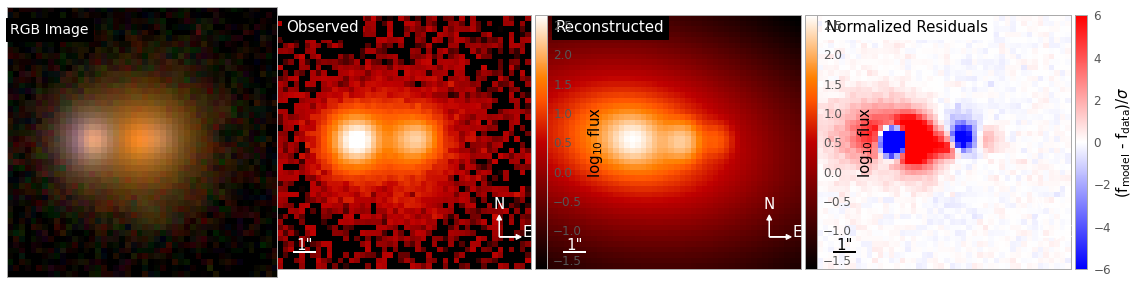

{'kwargs_lens': [{'theta_E': 0.7162907226084508, 'e1': -0.4011277059355124, 'e2': -0.06125902782125017, 'center_x': 1.1801703278245224, 'center_y': 0.13041213566250698}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 3096.157033881073, 'R_sersic': 0.9202867734462582, 'n_sersic': 1.9847176937771362, 'e1': 0.24005258285582193, 'e2': -0.0798124461952092, 'center_x': -1.981610299865957, 'center_y': 0.1206941103181161}], 'kwargs_ps': [{'ra_image': array([0.33379057, 1.95129454]), 'dec_image': array([0.03176732, 0.08668376]), 'point_amp': array([11750.08957068,  1136.54964911])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =0.72
Actual theta_E: 1.24 +- 0.02


In [28]:
# coadd_id = 1025921566
center_x=1.5
center_y=0.2

x_images = [-0.3,2.0]
y_images = [-0.2,0.1]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1212441684, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= None)

print('Actual theta_E: 1.24 +- 0.02')

'theta_E': 1.58


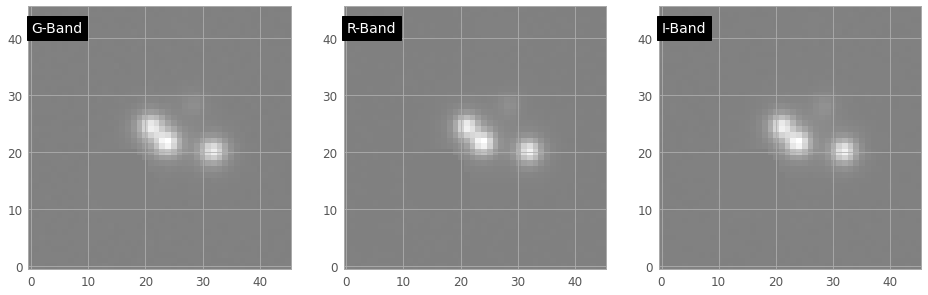

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-7.126465404910459 reduced X^2 of best position
-22498.25128330232 logL
6314.0 effective number of data points
[{'theta_E': 1.5287370060797711, 'e1': -0.2200789731620377, 'e2': 0.3291407898476562, 'center_x': 1.4032451090194218, 'center_y': 0.8794736419138031}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.0098208954935746, 'n_sersic': 3.0217623359995622, 'e1': 0.4742593436970953, 'e2': 0.27914189494284014, 'center_x': 1.4694450358063056, 'center_y': 0.874821250482478}] lens light result
[{'ra_image': array([-0.28604871,  0.37067311,  1.72594859,  2.45317198]), 'dec_image': array([ 0.4890416 , -0.32505039,  1.69611046, -0.65435297]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special param result
13.242577075958252 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [02:45<00:00,  1.04s/it]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  40
Sampling iterations (in current run): 160
167.0285620689392 time taken for MCMC sampling
-2.5908704861813363 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.6584379289908497
reduced chi^2 of data  1 =  2.8730576282652023
reduced chi^2 of data  2 =  4.241115901287958


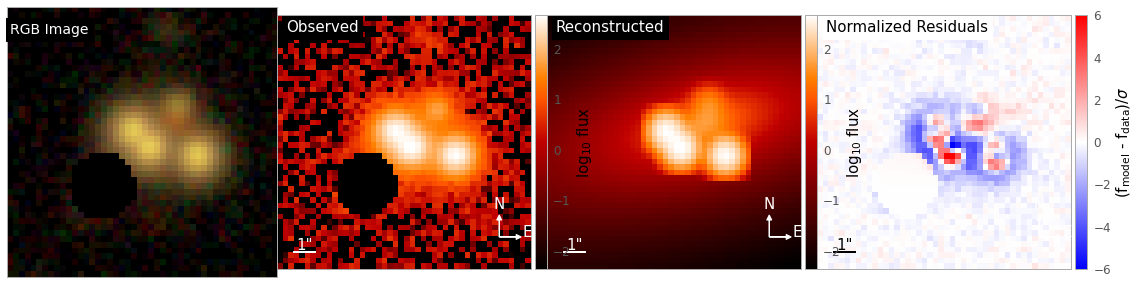

{'kwargs_lens': [{'theta_E': 1.6015723029214428, 'e1': -0.26915127494933994, 'e2': 0.36005272807962785, 'center_x': 1.3547226948290032, 'center_y': 1.0742721402075093}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 538.0300129207675, 'R_sersic': 0.9613546821738752, 'n_sersic': 2.805467220189464, 'e1': 0.4108608059153327, 'e2': 0.2121124788817099, 'center_x': 1.446245012850488, 'center_y': 0.8509153030233496}], 'kwargs_ps': [{'ra_image': array([-0.36464457,  0.32881672,  1.64153877,  2.45037619]), 'dec_image': array([ 0.50595315, -0.29269232,  1.77650637, -0.62672088]), 'point_amp': array([16665.96957709, 18588.57177983,  1254.34463458, 16971.86966541])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.6
Actual theta_E: 1.17 +- 0.01


In [39]:
# coadd_id = 1112574265
center_x=1.4
center_y=0.8

x_images = [-0.6,0.1,1.4,2.4]
y_images = [0.4,-0.4,1.5,-0.7]

image_amps_g = [3257.9, 4466.0, 486.3, 2943.4]
image_amps_r = [7325.2, 9878.9, 1151.5, 6761.2]
image_amps_i = [8538.2, 11588.7, 1511.8, 7924.5]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1112574265, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -1.8 , 'mask_center_y': -2.0, 'mask_radius':1.5}])

print('Actual theta_E: 1.17 +- 0.01')

'theta_E': 1.16


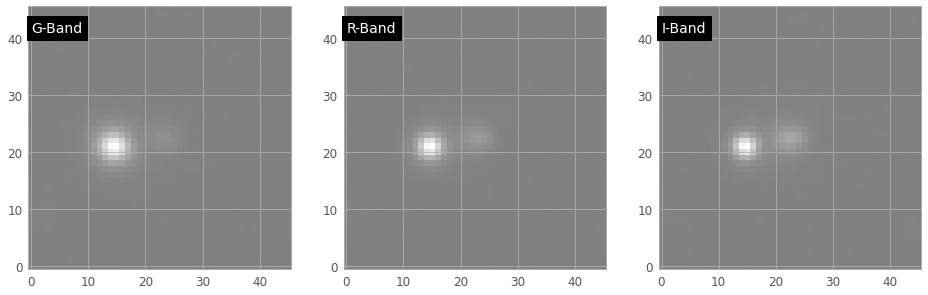

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.0782135719276664 reduced X^2 of best position
-3409.311314435281 logL
6324.0 effective number of data points
[{'theta_E': 1.2672445389196343, 'e1': -0.02693047166183971, 'e2': -0.14067456580511062, 'center_x': -0.12385791604177637, 'center_y': -0.01573437809370446}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9819534679050055, 'n_sersic': 1.9162088001443993, 'e1': 0.038657769510256304, 'e2': 0.07904091497349931, 'center_x': -0.26057461919751657, 'center_y': -0.06752752643442349}] lens light result
[{'ra_image': array([-2.08816088,  0.42646549]), 'dec_image': array([-0.41601305, -0.07171984]), 'point_amp': array([1., 1.])}] point source result
{} special param result
10.2100088596344 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [01:45<00:00,  1.52it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
105.99507808685303 time taken for MCMC sampling
-0.9946422792444133 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.6009631380368837
reduced chi^2 of data  1 =  0.7721510130727695
reduced chi^2 of data  2 =  1.6108126866235863


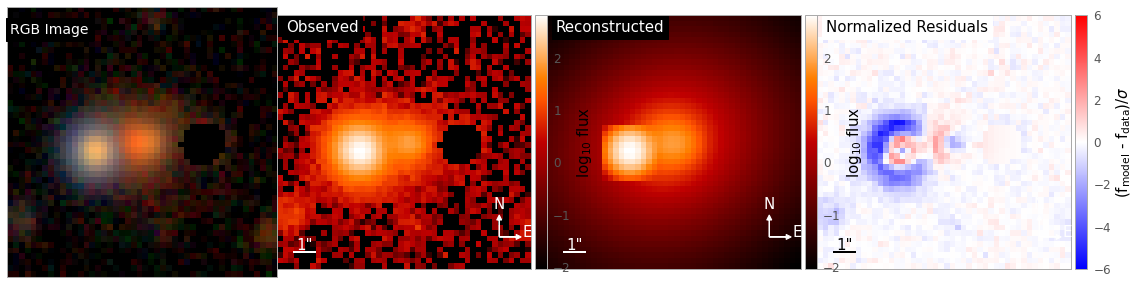

{'kwargs_lens': [{'theta_E': 1.2175601022581901, 'e1': -0.030002170010668974, 'e2': -0.15694322299096597, 'center_x': -0.10879814718663151, 'center_y': -0.025602634310681233}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1257.494547457437, 'R_sersic': 0.9621772307473228, 'n_sersic': 1.8922495697424366, 'e1': 0.051193363459926, 'e2': 0.05467959395911221, 'center_x': -0.2930008375443789, 'center_y': -0.050229929835966455}], 'kwargs_ps': [{'ra_image': array([-2.09265424,  0.32621125]), 'dec_image': array([-0.41881021, -0.06922634]), 'point_amp': array([20349.48868917,  2675.29943134])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.22
Actual theta_E: 1.22 +- 0.02


In [31]:
# 1596823754
center_x=-0.3
center_y=-0.1

x_images = [-2.3,0.5]
y_images = [-0.5,0.0]

image_amps_g = [9173.5, 1264.5]
image_amps_r = [13449.9, 3516.6]
image_amps_i = [17272.0, 7347.4]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1596823754, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': 2.7 , 'mask_center_y': -0.1, 'mask_radius':1}])

print('Actual theta_E: 1.22 +- 0.02')

'theta_E': 0.54


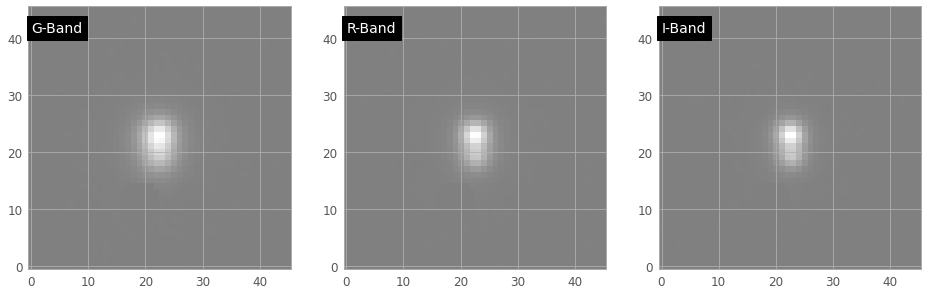

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-3.0353179019398 reduced X^2 of best position
-9597.675205933647 logL
6324.0 effective number of data points
[{'theta_E': 0.8433194362453014, 'e1': 0.2521747150318172, 'e2': 0.03399424601031166, 'center_x': -0.22557995577890588, 'center_y': -0.5355928817617785}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.5507265208991736, 'n_sersic': 2.278840287390905, 'e1': -0.17984303641647018, 'e2': 0.121507063605404, 'center_x': 0.01751776521088514, 'center_y': -0.8210842240975335}] lens light result
[{'ra_image': array([-0.03918919, -0.09533095]), 'dec_image': array([ 0.17285088, -1.59363544]), 'point_amp': array([1., 1.])}] point source result
{} special param result
11.90589165687561 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [01:44<00:00,  1.54it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
104.79987573623657 time taken for MCMC sampling
-2.672834651274598 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.1278531602748223
reduced chi^2 of data  1 =  2.3141259778391987
reduced chi^2 of data  2 =  3.576524815709773


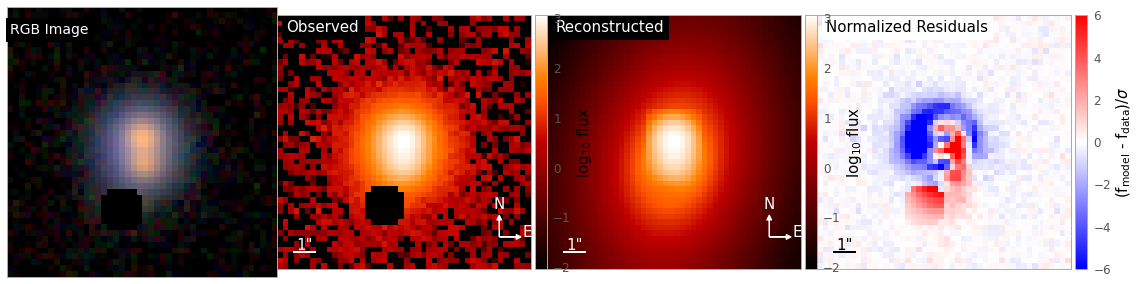

{'kwargs_lens': [{'theta_E': 0.8568729683994457, 'e1': 0.2619019188413332, 'e2': -0.014409412674012155, 'center_x': -0.24352166072513012, 'center_y': -0.5481578350051737}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 9525.871523141192, 'R_sersic': 0.5102948260127353, 'n_sersic': 2.3398756502143687, 'e1': -0.1917420007386929, 'e2': 0.08573068239410375, 'center_x': -0.007612834558002131, 'center_y': -0.8643194803984413}], 'kwargs_ps': [{'ra_image': array([-0.02386813, -0.21855153]), 'dec_image': array([ 0.16108534, -1.63575748]), 'point_amp': array([31484.56126051, -4245.68993719])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =0.86
Actual theta_E: 0.49 +- 0.01


In [32]:
# 1331771342
center_x=-0.2
center_y=-0.6

x_images = [-0.2,-0.2]
y_images = [0.1,-1.2]

image_amps_g = [15085.5, 9339.1]
image_amps_r = [19260.6, 11343.2]
image_amps_i = [26034.6, 15140.8]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1331771342, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -0.9 , 'mask_center_y': -3.0, 'mask_radius':1}])


print('Actual theta_E: 0.49 +- 0.01')

'theta_E': 2.93


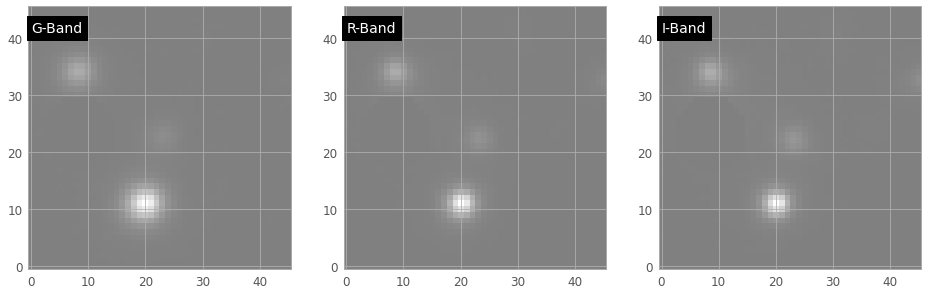

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-66.61734035266318 reduced X^2 of best position
-210477.4868442393 logL
6319.0 effective number of data points
[{'theta_E': 3.184650494559615, 'e1': -0.02004060859239745, 'e2': 0.49789671794599055, 'center_x': -0.6683529543471236, 'center_y': -0.5607546033902172}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.39888155067530084, 'n_sersic': 1.2429164662368768, 'e1': 0.07017516613168123, 'e2': -0.01040798516630637, 'center_x': 0.07621663156448659, 'center_y': -0.18887518482048954}] lens light result
[{'ra_image': array([-4.18190879, -0.67970536,  0.99408915]), 'dec_image': array([ 2.4060978 , -3.00887257,  0.24467549]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
4.656840085983276 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [02:02<00:00,  1.30it/s]


Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  40
Sampling iterations (in current run): 160
123.39506721496582 time taken for MCMC sampling
-25.09567623743726 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  7.2495926353820215
reduced chi^2 of data  1 =  21.423824399373142
reduced chi^2 of data  2 =  46.613611677556605


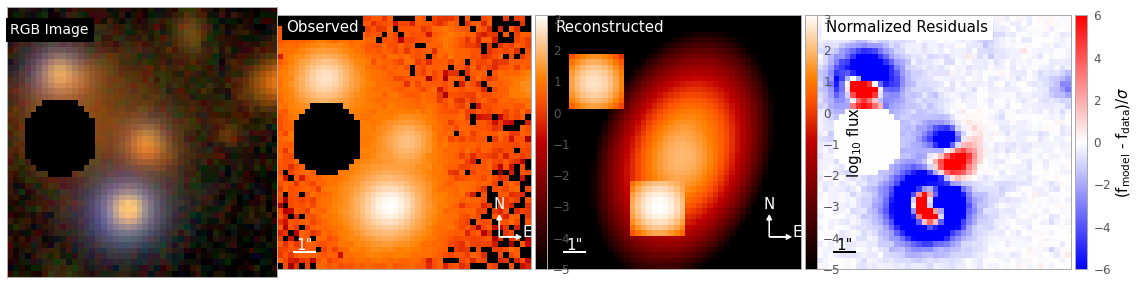

{'kwargs_lens': [{'theta_E': 3.197924119308977, 'e1': 0.16746823039321404, 'e2': 0.47648218977780227, 'center_x': -0.82692272662263, 'center_y': -0.39464286448752567}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 2958.9577646403845, 'R_sersic': 0.7350229923920313, 'n_sersic': 0.5915956113507452, 'e1': -0.22081214780453653, 'e2': 0.17363417778269905, 'center_x': 0.41860493802802534, 'center_y': -0.6086069031534648}], 'kwargs_ps': [{'ra_image': array([-3.80446854, -0.70460418,  0.98418914]), 'dec_image': array([ 2.82973196, -3.06847601,  0.09428402]), 'point_amp': array([15966.89358254, 38504.45057375,  -541.57678407])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =3.2
Actual theta_E: n/a


In [42]:
# 1406996169
center_x=-0.1
center_y=-0.3

x_images = [-3.9,-0.8,0.3]
y_images = [3.1,-3.2,0.3]

# image amps
image_amps_g = [5951.0, 17839.2, 1793.9]
image_amps_r = [9358.5, 24711.4, 4062.2]
image_amps_i = [13043.8, 30729.8, 6738.3]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic':2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

model(coadd_id = 1406996169, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': -3.7 , 'mask_center_y': 0.2, 'mask_radius':1.7}])

print('Actual theta_E: n/a')

'theta_E': 1.66


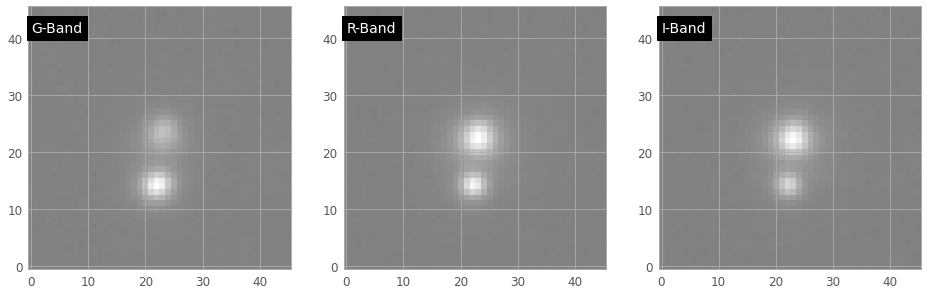

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.4274669674357066 reduced X^2 of best position
-1351.6505510317043 logL
6324.0 effective number of data points
[{'theta_E': 1.742457011414874, 'e1': -0.21795272512629874, 'e2': 0.029836662548752828, 'center_x': -0.0174802912239014, 'center_y': -0.7706811978654245}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.064144270469462, 'n_sersic': 2.4927319440566325, 'e1': 0.06870368211768652, 'e2': 0.02309654200218807, 'center_x': 0.1218275820894732, 'center_y': -0.07246324419758901}] lens light result
[{'ra_image': array([-0.08256855,  0.17174246]), 'dec_image': array([-2.17321596,  0.99385847]), 'point_amp': array([1., 1.])}] point source result
{} special param result
10.705356121063232 time used for  PSO


100%|█████████████████████████████████████████| 160/160 [01:44<00:00,  1.53it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  40
Sampling iterations (in current run): 160
105.13776469230652 time taken for MCMC sampling
-0.399048419799345 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.24840207864593386
reduced chi^2 of data  1 =  0.3143776838066581
reduced chi^2 of data  2 =  0.6343654969454431


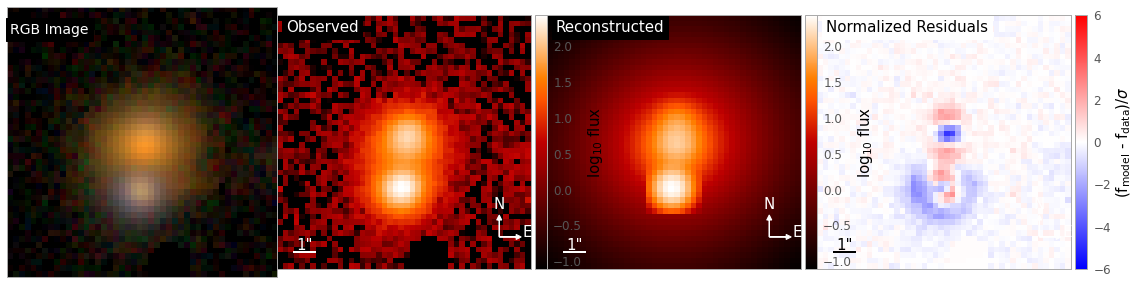

{'kwargs_lens': [{'theta_E': 1.7421687415796125, 'e1': -0.25021868935458064, 'e2': 0.031203181892958648, 'center_x': -0.06669790032584148, 'center_y': -0.7459973307756338}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1757.304588981574, 'R_sersic': 1.0793363984136086, 'n_sersic': 2.6314391389983633, 'e1': 0.030034771677340862, 'e2': 0.018727079392756606, 'center_x': 0.11949976303607966, 'center_y': -0.06500444845006938}], 'kwargs_ps': [{'ra_image': array([-0.08621165,  0.15819228]), 'dec_image': array([-2.17586887,  0.9309332 ]), 'point_amp': array([7011.13714926, -164.46779818])}], 'kwargs_special': {}, 'kwargs_extinction': []}
Model Results: theta_E =1.74
Actual theta_E: 1.30 +- 0.02


In [40]:
# 1456100148
center_x=-0.1
center_y=-0.3

x_images = [-0.3,-0.0]
y_images = [-2.4,0.9]

image_amps_g = [5167.5, 3355.0]
image_amps_r = [6384.3, 9323.4]
image_amps_i = [7975.6, 14633.2]

theta_E=approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0, 'center_x': center_x, 'center_y': center_y}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model
model(coadd_id = 1456100148, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images, y_images = y_images, 
      image_amps_g=image_amps_g, image_amps_r=image_amps_r, image_amps_i=image_amps_i,
      mask_list= [{'mask_center_x': 1.2 , 'mask_center_y': -5.5, 'mask_radius':1}])

print('Actual theta_E: 1.30 +- 0.02')